In [3]:
pip install tensorflow


     -------------------------------------- 266.3/266.3 MB 3.8 MB/s eta 0:00:00
     ---------------------------------------- 23.2/23.2 MB 6.1 MB/s eta 0:00:00
     ---------------------------------------- 1.5/1.5 MB 7.3 MB/s eta 0:00:00
     -------------------------------------- 895.9/895.9 kB 7.1 MB/s eta 0:00:00
     ---------------------------------------- 3.7/3.7 MB 8.0 MB/s eta 0:00:00
     -------------------------------------- 439.2/439.2 kB 9.1 MB/s eta 0:00:00
     ---------------------------------------- 6.0/6.0 MB 7.5 MB/s eta 0:00:00
     -------------------------------------- 126.5/126.5 kB 3.8 MB/s eta 0:00:00
     ---------------------------------------- 1.7/1.7 MB 7.2 MB/s eta 0:00:00
     ---------------------------------------- 65.5/65.5 kB 3.5 MB/s eta 0:00:00
     ---------------------------------------- 57.5/57.5 kB 3.1 MB/s eta 0:00:00
     -------------------------------------- 781.3/781.3 kB 7.1 MB/s eta 0:00:00
     -------------------------------------- 177

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical

from sklearn.metrics import confusion_matrix , classification_report 
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import roc_curve, auc, roc_auc_score

from IPython.display import clear_output
import warnings
warnings.filterwarnings('ignore')

## Ordering labels file 

In [6]:
df = pd.read_csv('portrait_images_labels_sorted.csv')
df

,filename,emotion,label
0,image_00001.jpg,sad,2
1,image_00003.jpg,sad,2
2,image_00004.jpg,angry,1
3,image_00005.jpg,neutral,7
4,image_00006.jpg,neutral,7
...,...,...,...
5831,image_08210.jpg,neutral,7
5832,image_08211.jpg,neutral,7
5833,image_08212.jpg,fear,4
5834,image_08215.jpg,sad,2


In [36]:
df_t = pd.read_csv('rijks_emotion_cluster1.csv')
df_t = df_t.sort_values(by='filename', ascending=True)
df_t
df_t.to_csv('rijks_emotion_cluster1_sorted.csv', index=False)
df_test = pd.read_csv('rijks_emotion_cluster1_sorted.csv')
df_test

,filename,emotion
0,img_1.jpg,surprised
1,img_10.jpg,disgust
2,img_100.jpg,angry
3,img_101.jpg,fear
4,img_102.jpg,angry
...,...,...
761,img_95.jpg,surprised
762,img_96.jpg,surprised
763,img_97.jpg,happy
764,img_98.jpg,happy


## Organizing into folders for model training

In [17]:
from PIL import Image

## We want 4,837 images in the 'train' folder
for i in range(0, 4836):
    img_filename = df.iloc[i]['filename']
    emotion = df.iloc[i]['emotion']
    image = Image.open('portrait_faces/' + img_filename)
    image.save('train/' + emotion + '/' + img_filename)

## Remaining (1,000) go into 'test' folder
for i in range(4836, len(df)):
    img_filename = df.iloc[i]['filename']
    emotion = df.iloc[i]['emotion']
    image = Image.open('portrait_faces/' + img_filename)
    image.save('test/' + emotion + '/' + img_filename)

In [37]:
from PIL import Image

for i in range(0, len(df_test)):
    img_filename = df_test.iloc[i]['filename']
    emotion = df_test.iloc[i]['emotion']
    image = Image.open('cropped_images/' + img_filename)
    image.save('final_test/' + emotion + '/' + img_filename.rsplit('/', 1)[-1])

## Hyperparameters and directories

In [72]:
train_dir = "train/"
test_dir = "test/"
test_art = 'test_art/'
final_test = 'final_test/'

SEED = 12
IMG_HEIGHT = 48
IMG_WIDTH = 48
BATCH_SIZE = 64
EPOCHS = 30
FINE_TUNING_EPOCHS = 20
LR = 0.01
NUM_CLASSES = 7
EARLY_STOPPING_CRITERIA = 5
CLASS_LABELS  = ['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprised']

In [73]:
preprocess_fun = tf.keras.applications.densenet.preprocess_input

#preprocessing training and test data
train_datagen = ImageDataGenerator(horizontal_flip = True,
                                   width_shift_range = 0.1,
                                   height_shift_range = 0.05,
                                   rescale = 1./255,
                                   validation_split = 0.2,
                                   preprocessing_function = preprocess_fun
)

test_datagen = ImageDataGenerator(rescale = 1./255,
                                  validation_split = 0.2,
                                  preprocessing_function = preprocess_fun
)

train_generator = train_datagen.flow_from_directory(directory = train_dir,
                                                    target_size = (IMG_HEIGHT ,IMG_WIDTH),
                                                    batch_size = BATCH_SIZE,
                                                    shuffle  = True , 
                                                    color_mode = "rgb",
                                                    class_mode = "categorical",
                                                    subset = "training",
                                                    seed = 12
)

validation_generator = test_datagen.flow_from_directory(directory = train_dir,
                                                         target_size = (IMG_HEIGHT ,IMG_WIDTH),
                                                         batch_size = BATCH_SIZE,
                                                         shuffle  = True , 
                                                         color_mode = "rgb",
                                                         class_mode = "categorical",
                                                         subset = "validation",
                                                         seed = 12
)

test_generator = test_datagen.flow_from_directory(directory = test_dir,
                                                   target_size = (IMG_HEIGHT ,IMG_WIDTH),
                                                    batch_size = BATCH_SIZE,
                                                    shuffle  = False , 
                                                    color_mode = "rgb",
                                                    class_mode = "categorical",
                                                    seed = 12
)

Found 3872 images belonging to 7 classes.
Found 964 images belonging to 7 classes.
Found 1000 images belonging to 7 classes.


In [97]:
preprocess_fun = tf.keras.applications.densenet.preprocess_input

finaltest_datagen = ImageDataGenerator(
    rescale = 1./255,
    validation_split = 0.2,
    preprocessing_function = preprocess_fun
) 

finaltest_generator = finaltest_datagen.flow_from_directory(directory = final_test,
                                                   target_size = (IMG_HEIGHT ,IMG_WIDTH),
                                                    batch_size = BATCH_SIZE,
                                                    shuffle  = False , 
                                                    color_mode = "rgb",
                                                    class_mode = "categorical",
                                                    seed = 12
)

Found 766 images belonging to 7 classes.


## Helper functions

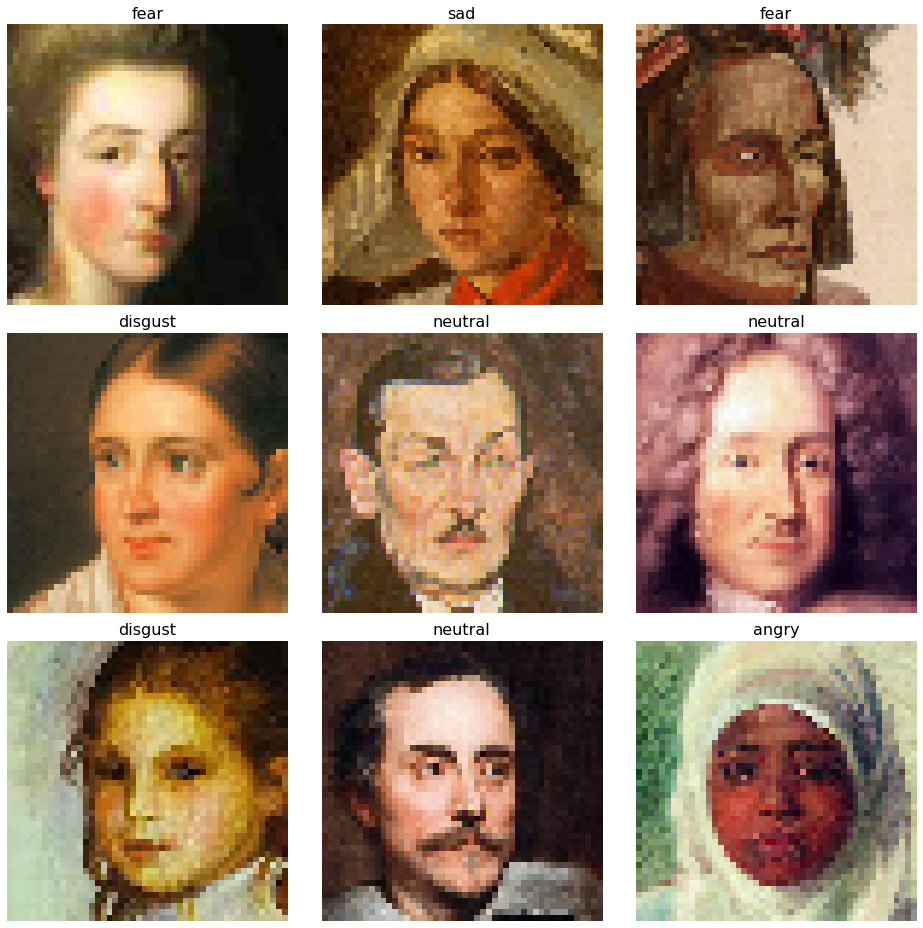

In [76]:
#to show one image with its label (emotion)
def display_one_image(image, title, subplot, color):
    plt.subplot(subplot)
    plt.axis('off')
    plt.imshow(image)
    plt.title(title, fontsize=16)
    
#to show nine images with its labels (emotions)
def display_nine_images(images, titles, title_colors=None):
    subplot = 331
    plt.figure(figsize=(13,13))
    for i in range(9):
        color = 'black' if title_colors is None else title_colors[i]
        display_one_image(images[i], titles[i], 331+i, color)
    plt.tight_layout()
    plt.subplots_adjust(wspace = 0.1, hspace = 0.1)
    plt.show()

def image_title(label, prediction):
  # Both prediction (probabilities) and label (one-hot) are arrays with one item per class.
    class_idx = np.argmax(label, axis=-1)
    prediction_idx = np.argmax(prediction, axis=-1)
    if class_idx == prediction_idx:
        return f'{CLASS_LABELS[prediction_idx]} [correct]', 'black'
    else:
        return f'{CLASS_LABELS[prediction_idx]} [incorrect, should be {CLASS_LABELS[class_idx]}]', 'red'

#to get an image and it's "labeled emotion"
def get_titles(images, labels, model):
    predictions = model.predict(images)
    titles, colors = [], []
    for label, prediction in zip(classes, predictions):
        title, color = image_title(label, prediction)
        titles.append(title)
        colors.append(color)
    return titles, colors

img_datagen = ImageDataGenerator(rescale = 1./255)
img_generator = img_datagen.flow_from_directory(directory = train_dir,
                                                   target_size = (IMG_HEIGHT ,IMG_WIDTH),
                                                    batch_size = BATCH_SIZE,
                                                    shuffle  = True , 
                                                    color_mode = "rgb",
                                                    class_mode = "categorical",
                                                    seed = 12
)

clear_output()

images, classes = next(img_generator)
class_idxs = np.argmax(classes, axis=-1) 
labels = [CLASS_LABELS[idx] for idx in class_idxs]
display_nine_images(images, labels)

## Data distribution in training data

In [61]:
!pip install plotly

In [62]:
import plotly

In [80]:
import plotly.express as px

fig = px.bar(
    x = CLASS_LABELS,
    y = [list(train_generator.classes).count(i) for i in np.unique(train_generator.classes)], 
    color = np.unique(train_generator.classes),
    color_continuous_scale="Emrld"
)

fig.update_xaxes(title="Emotions")
fig.update_yaxes(title = "No. of Images")
fig.update_layout(
    showlegend = True,
    title = {
        'text': 'Train Data Distribution ',
        'y':0.95,
        'x':0.5,
        'xanchor': 'center',
        'yanchor': 'top'
    }
)

fig.show()

## DenseNet169 TRANSFER LEARNING

In [86]:
#given a dataset of images, extracts features that classify emotions
def feature_extractor(inputs):
    feature_extractor = tf.keras.applications.DenseNet169(
        input_shape=(IMG_HEIGHT,IMG_WIDTH, 3),
        include_top = False,
        weights = "imagenet"
    )(inputs)
    return feature_extractor

def classifier(inputs):
    x = tf.keras.layers.GlobalAveragePooling2D()(inputs)
    x = tf.keras.layers.Dense(256, activation="relu", kernel_regularizer = tf.keras.regularizers.l2(0.01))(x)
    x = tf.keras.layers.Dropout(0.3)(x)
    x = tf.keras.layers.Dense(1024, activation="relu", kernel_regularizer = tf.keras.regularizers.l2(0.01))(x)
    x = tf.keras.layers.Dropout(0.5)(x)
    x = tf.keras.layers.Dense(512, activation="relu", kernel_regularizer = tf.keras.regularizers.l2(0.01))(x)
    x = tf.keras.layers.Dropout(0.5) (x)
    x = tf.keras.layers.Dense(NUM_CLASSES, activation="softmax", name="classification")(x)
    return x

def final_model(inputs):
    densenet_feature_extractor = feature_extractor(inputs)
    classification_output = classifier(densenet_feature_extractor)
    return classification_output

#compiles the model
#this is where the model learns to recognize emotions
def define_compile_model():
    inputs = tf.keras.layers.Input(shape=(IMG_HEIGHT ,IMG_WIDTH,3))
    classification_output = final_model(inputs) 
    model = tf.keras.Model(inputs=inputs, outputs = classification_output)
     
    model.compile(
        optimizer=tf.keras.optimizers.SGD(0.1), 
        loss='categorical_crossentropy',
        metrics = ['accuracy']
    )
    
    return model

## Summary of the model

In [87]:
model = define_compile_model()
clear_output()

# Feezing the feature extraction layers
model.layers[1].trainable = False

model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 48, 48, 3)]       0         
                                                                 
 densenet169 (Functional)    (None, 1, 1, 1664)        12642880  
                                                                 
 global_average_pooling2d_1   (None, 1664)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_3 (Dense)             (None, 256)               426240    
                                                                 
 dropout_3 (Dropout)         (None, 256)               0         
                                                                 
 dense_4 (Dense)             (None, 1024)              263168    
                                                           

In [88]:
earlyStoppingCallback = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', 
    patience=EARLY_STOPPING_CRITERIA,
    verbose=1,
    restore_best_weights=True
)

history = model.fit(
    x = train_generator,
    epochs = EPOCHS,
    validation_data = validation_generator, 
    callbacks = [earlyStoppingCallback]
)

history = pd.DataFrame(history.history)

Epoch 1/30
61/61 [==============================] - 132s 2s/step - loss: 15.5075 - accuracy: 0.2110 - val_loss: 13.7918 - val_accuracy: 0.2075
Epoch 2/30
61/61 [==============================] - 118s 2s/step - loss: 12.3472 - accuracy: 0.2939 - val_loss: 11.1889 - val_accuracy: 0.2417
Epoch 3/30
61/61 [==============================] - 104s 2s/step - loss: 9.8516 - accuracy: 0.3507 - val_loss: 9.2468 - val_accuracy: 0.1940
Epoch 4/30
61/61 [==============================] - 101s 2s/step - loss: 7.9352 - accuracy: 0.4150 - val_loss: 7.6105 - val_accuracy: 0.2396
Epoch 5/30
61/61 [==============================] - 95s 2s/step - loss: 6.4521 - accuracy: 0.4533 - val_loss: 6.4225 - val_accuracy: 0.2147
Epoch 6/30
61/61 [==============================] - 93s 2s/step - loss: 5.2781 - accuracy: 0.4845 - val_loss: 5.4543 - val_accuracy: 0.2127
Epoch 7/30
61/61 [==============================] - 92s 2s/step - loss: 4.3649 - accuracy: 0.5077 - val_loss: 4.7956 - val_accuracy: 0.2230
Epoch 8/30
6

## Fine-tuning

In [89]:
# Un-Freezing the feature extraction layers for fine tuning 
model.layers[1].trainable = True

model.compile(
    optimizer = tf.keras.optimizers.SGD(0.001), #lower learning rate
    loss = 'categorical_crossentropy',
    metrics = ['accuracy']
)

history_ = model.fit(x = train_generator, epochs = FINE_TUNING_EPOCHS, validation_data = validation_generator)
history = history.append(pd.DataFrame(history_.history), ignore_index = True)

Epoch 1/20
61/61 [==============================] - 107s 2s/step - loss: 0.5669 - accuracy: 0.8357 - val_loss: 1.6193 - val_accuracy: 0.4948
Epoch 2/20
61/61 [==============================] - 93s 2s/step - loss: 0.5341 - accuracy: 0.8404 - val_loss: 1.5248 - val_accuracy: 0.5218
Epoch 3/20
61/61 [==============================] - 91s 1s/step - loss: 0.4853 - accuracy: 0.8673 - val_loss: 1.5030 - val_accuracy: 0.5290
Epoch 4/20
61/61 [==============================] - 91s 1s/step - loss: 0.4772 - accuracy: 0.8642 - val_loss: 1.4984 - val_accuracy: 0.5363
Epoch 5/20
61/61 [==============================] - 91s 1s/step - loss: 0.4602 - accuracy: 0.8796 - val_loss: 1.5058 - val_accuracy: 0.5280
Epoch 6/20
61/61 [==============================] - 91s 1s/step - loss: 0.4399 - accuracy: 0.8838 - val_loss: 1.5110 - val_accuracy: 0.5249
Epoch 7/20
61/61 [==============================] - 92s 2s/step - loss: 0.4218 - accuracy: 0.8972 - val_loss: 1.5192 - val_accuracy: 0.5290
Epoch 8/20
61/61 [=

## Training some plots

In [90]:
x = px.line(data_frame = history, y = ["accuracy" , "val_accuracy"], markers = True)

x.update_xaxes(title="No. of Epochs")
x.update_yaxes(title = "Accuracy")
x.update_layout(
    showlegend = True,
    title = {
        'text': 'Accuracy vs Number of Epochs',
        'y':0.94,
        'x':0.5,
        'xanchor': 'center',
        'yanchor': 'top'
    }
)

x.show()

In [91]:
x = px.line(data_frame = history, y = ["loss" , "val_loss"], markers = True)

x.update_xaxes(title="No. of Epochs")
x.update_yaxes(title = "Loss")
x.update_layout(
    showlegend = True,
    title = {
        'text': 'Loss vs Number of Epochs',
        'y':0.94,
        'x':0.5,
        'xanchor': 'center',
        'yanchor': 'top'
    }
)

x.show()

## Visualizing Results

### Testing model on test directory

In [92]:
# Evaluate the model on test data
model.evaluate(test_generator)

# Make predictions on test data
preds = model.predict(test_generator)

# Convert predictions into a numpy array
y_preds = np.argmax(preds, axis=1)

# Convert test labels into a numpy array
y_test = np.array(test_generator.labels)

16/16 [==============================] - 15s 791ms/step


In [104]:
# Place class labels as per predictions 
labels = (train_generator.class_indices)
labels = dict((v,k) for k,v in labels.items())

test_predictions = pd.DataFrame([labels[y_pred] for y_pred in y_preds], columns=['predicted_label'])
test_predictions.insert(0, column='filename', value=[df.iloc[i]['filename'] for i in range(4836, len(df))])
test_predictions['actual_label'] = [df.iloc[i]['emotion'] for i in range(4836, len(df))]
test_predictions

,filename,predicted_label,actual_label
0,image_06803.jpg,neutral,angry
1,image_06804.jpg,sad,disgust
2,image_06805.jpg,sad,fear
3,image_06806.jpg,fear,disgust
4,image_06807.jpg,angry,angry
...,...,...,...
995,image_08210.jpg,angry,neutral
996,image_08211.jpg,sad,neutral
997,image_08212.jpg,neutral,fear
998,image_08215.jpg,sad,sad


In [118]:
test_predictions.to_csv('predictions/test_predictions.csv', index=False)

#### Computing accuracy

In [108]:
correct = (test_predictions['predicted_label'] == test_predictions['actual_label'])
accuracy = correct.sum() / 1000
accuracy

0.196

In [107]:
print(classification_report(y_test, y_preds))

              precision    recall  f1-score   support

           0       0.52      0.56      0.54       119
           1       0.57      0.59      0.58       183
           2       0.49      0.48      0.48       181
           3       0.23      0.13      0.17        38
           4       0.53      0.46      0.49       228
           5       0.48      0.54      0.51       250
           6       0.00      0.00      0.00         1

    accuracy                           0.51      1000
   macro avg       0.40      0.39      0.40      1000
weighted avg       0.50      0.51      0.50      1000



#### Confusion matrix

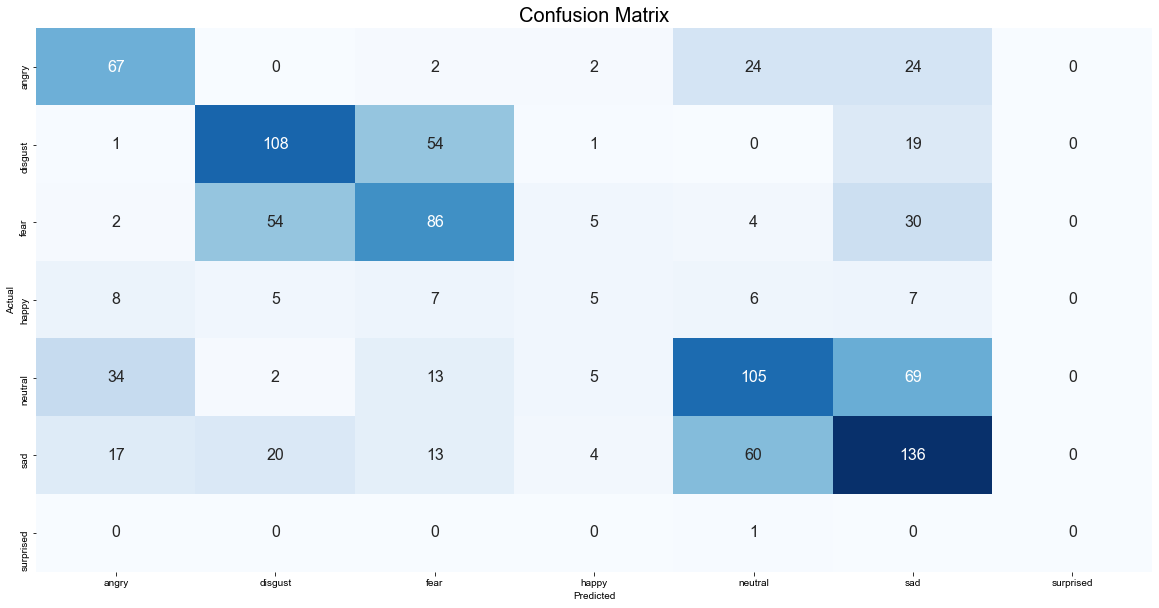

In [109]:
cm_data = confusion_matrix(y_test, y_preds)
cm = pd.DataFrame(cm_data, columns=CLASS_LABELS, index=CLASS_LABELS)
cm.index.name = 'Actual'
cm.columns.name = 'Predicted'
plt.figure(figsize = (20,10))
plt.title('Confusion Matrix', fontsize = 20)
sns.set(font_scale=1.2)
ax = sns.heatmap(cm, cbar=False, cmap="Blues", annot=True, annot_kws={"size": 16}, fmt='g')

### Testing model on Rijksmuseum data

In [110]:
# Evaluate the model on Rijksmuseum test data
model.evaluate(finaltest_generator)

# Make predictions on Rijksmuseum test data
rijks_preds = model.predict(finaltest_generator)

# Convert predictions into a numpy array
y_preds = np.argmax(rijks_preds, axis=1)

# Convert test labels into a numpy array
y_test = np.array(finaltest_generator.labels)

12/12 [==============================] - 4s 335ms/step


In [114]:
# Place class labels as per predictions 
labels = (train_generator.class_indices)
labels = dict((v,k) for k,v in labels.items())

rijks_predictions = pd.DataFrame([labels[y_pred] for y_pred in y_preds], columns=['predicted_label'])
rijks_predictions.insert(0, column='filename', value=[df_test.iloc[i]['filename'] for i in range(0, len(df_test))])
rijks_predictions['actual_label'] = [df_test.iloc[i]['emotion'] for i in range(0, len(df_test))]
rijks_predictions['actual_label'] = rijks_predictions['actual_label'].apply(str.lower)
rijks_predictions

,filename,predicted_label,actual_label
0,cropped_images/img_1.jpg,fear,neutral
1,cropped_images/img_2.jpg,fear,neutral
2,cropped_images/img_3.jpg,disgust,neutral
3,cropped_images/img_4.jpg,fear,neutral
4,cropped_images/img_5.jpg,sad,angry
...,...,...,...
761,cropped_images/img_762.jpg,fear,sad
762,cropped_images/img_763.jpg,happy,neutral
763,cropped_images/img_764.jpg,fear,neutral
764,cropped_images/img_765.jpg,fear,happy


#### Computing accuracy

In [115]:
correct = (rijks_predictions['predicted_label'] == rijks_predictions['actual_label'])
accuracy = correct.sum() / 766
accuracy

0.05483028720626632

In [116]:
print(classification_report(y_test, y_preds))

              precision    recall  f1-score   support

           0       0.13      0.03      0.05        59
           1       0.01      0.03      0.02        31
           2       0.01      0.67      0.03         9
           3       0.03      0.02      0.02       124
           4       0.47      0.03      0.06       465
           5       0.08      0.24      0.12        50
           6       0.00      0.00      0.00        28

    accuracy                           0.05       766
   macro avg       0.11      0.15      0.04       766
weighted avg       0.30      0.05      0.05       766



#### Confusion matrix

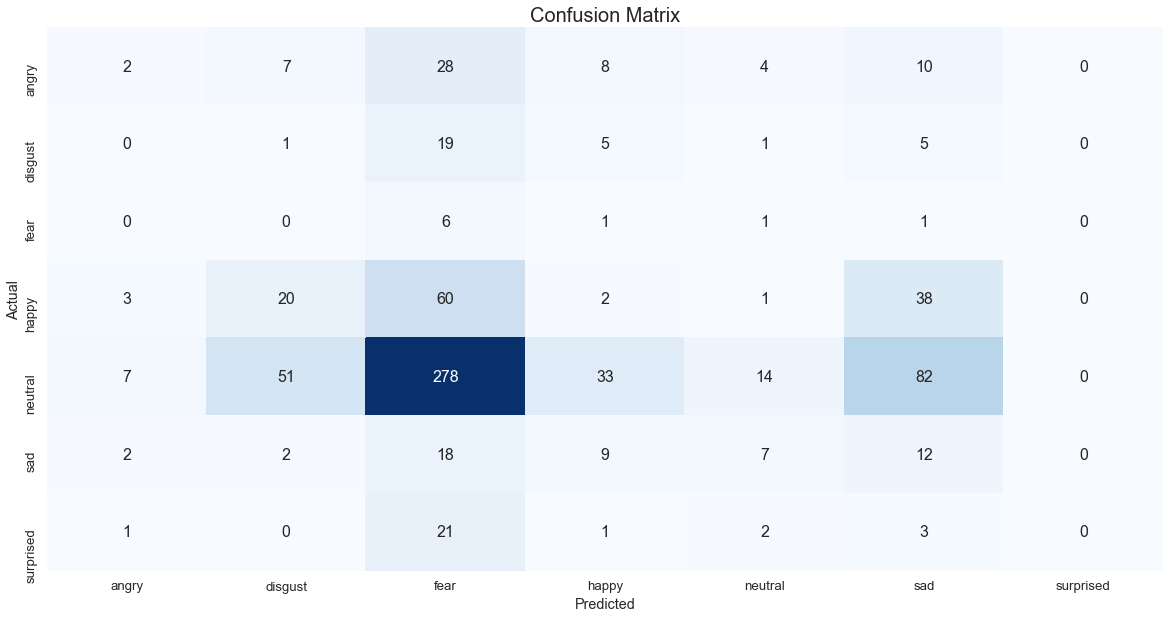

In [117]:
cm_data = confusion_matrix(y_test, y_preds)
cm = pd.DataFrame(cm_data, columns=CLASS_LABELS, index=CLASS_LABELS)
cm.index.name = 'Actual'
cm.columns.name = 'Predicted'
plt.figure(figsize = (20,10))
plt.title('Confusion Matrix', fontsize = 20)
sns.set(font_scale=1.2)
ax = sns.heatmap(cm, cbar=False, cmap="Blues", annot=True, annot_kws={"size": 16}, fmt='g')